##  A neural Network replacing the simple xgboost regression algorithm

#### Importing all libraries and setting the device to gpu

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import random

# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [5]:
import random
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU
    
set_seeds()

#### Pre processing the data and adding data indicators to the data

In [6]:
df = pd.read_csv("../../data/mahanagar-gas/mahanagar_gas.csv")
# Need to reverse the db
# df = df.loc[::-1]
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 2020)].copy()
df.index = range(len(df))
temp = df
# df['Close'] = (df['High'] + df['Low'] )/ 2
df.rename(columns={"Open Price":"Open","High Price":"High","Low Price":"Low","Close Price":"Close","Total Traded Quantity":"Volume","No.of Shares":"Volume","Price":"Close"},inplace=True)
# cols = ["Symbol","Ser verbose=Falseies","Prev Close","Last Price","Average Price","Turnover","No. of Trades", "Deliverable Qty",'% Dly Qt to Traded Qty']
# cols = ["WAP","No. of Trades"	,"Total Turnover (Rs.)"	,"Deliverable Quantity"	,"% Deli. Qty to Traded Qty"	,"Spread High-Low"	,"Spread Close-Open"]
# cols = "Adj Close"
cols = "Change(%)"
df.drop(columns=cols,inplace=True)   
df.dropna(inplace=True)
df.head()

,Date,Close,Open,High,Low,Volume
0,2023-08-16,982.10,984.8,987.05,970.55,327673
1,2023-08-14,985.80,995.8,995.80,976.00,465280
2,2023-08-11,1011.10,1032.0,1032.00,1008.10,656045
3,2023-08-10,1026.85,1060.0,1064.55,1021.05,698420
4,2023-08-09,1064.55,1071.2,1071.90,1057.60,338087


In [7]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0    
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

df['Close'] = df['Close'].shift(-1)

df = df.iloc[33:] # Because of moving average
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

df.head()

,Date,Close,Open,High,Low,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2023-06-28,1045.65,1044.0,1052.40,1028.20,397465,1082.234550,1077.13,1090.750,1083.686667,1082.943333,41.579690,-3.524954,2.237838
1,2023-06-27,1029.30,1034.7,1062.35,1032.05,1228102,1077.334819,1063.23,1085.745,1081.596667,1083.201667,46.009772,-5.392494,0.528200
2,2023-06-26,1016.55,1011.0,1034.90,1010.00,223902,1074.084989,1056.36,1078.955,1080.343333,1082.571667,37.691687,-8.020759,-1.342263
3,2023-06-23,1037.65,1037.0,1040.00,1013.50,371563,1069.503272,1047.80,1070.685,1078.273333,1081.151667,32.924602,-10.947789,-3.405127
4,2023-06-22,1039.25,1038.0,1069.00,1035.00,679027,1064.098357,1034.92,1062.340,1074.373333,1079.575000,38.814850,-11.512142,-5.120853


In [8]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']
df.drop(columns=drop_cols,inplace=True)
df.head()

,Close,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,1045.65,1082.234550,1077.13,1090.750,1083.686667,1082.943333,41.579690,-3.524954,2.237838
1,1029.30,1077.334819,1063.23,1085.745,1081.596667,1083.201667,46.009772,-5.392494,0.528200
2,1016.55,1074.084989,1056.36,1078.955,1080.343333,1082.571667,37.691687,-8.020759,-1.342263
3,1037.65,1069.503272,1047.80,1070.685,1078.273333,1081.151667,32.924602,-10.947789,-3.405127
4,1039.25,1064.098357,1034.92,1062.340,1074.373333,1079.575000,38.814850,-11.512142,-5.120853


#### Separating the data into train and test splits. Then splitting into validation split

In [9]:
X = df.iloc[:, 1:]
y = df.iloc[:, 1]

x_len = int(0.8 * len(X))
y_len = int(0.8 * len(y))
X_trainval = X[:x_len]
X_test = X[x_len:]
y_trainval = y[:y_len]
y_test = y[y_len:]

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2
)

#### Normalising the data

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

#### Initialising the dataset

In [11]:
class RegressionDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)   

In [12]:
train_dataset = RegressionDataset(
    torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
)
val_dataset = RegressionDataset(
    torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()
)
test_dataset = RegressionDataset(
    torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
)

#### Setting hyper parameters

In [13]:
EPOCHS = 1800
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

In [14]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [15]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()

        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [16]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [17]:
loss_stats = {
    'train': [],
    "val": []
}

In [18]:
for e in tqdm(range(1, EPOCHS + 1)):
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(
            device
        )
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))

        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()

    # VALIDATION
    with torch.no_grad():
        val_epoch_loss = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))

            val_epoch_loss += val_loss.item()
        # print(torch.cuda.get_device_name())

        loss_stats["train"].append(train_epoch_loss / len(train_loader))
        loss_stats["val"].append(val_epoch_loss / len(val_loader))

    if e % 50 == 0:
        print(
            f"Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}"
        )
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

  0%|          | 0/1800 [00:00<?, ?it/s]

  3%|▎         | 62/1800 [00:05<00:54, 31.95it/s] 

Epoch 050: | Train Loss: 27553.13368 | Val Loss: 26557.04622


  6%|▋         | 117/1800 [00:05<00:20, 83.63it/s]

Epoch 100: | Train Loss: 18451.56543 | Val Loss: 17347.11100


 10%|▉         | 173/1800 [00:05<00:14, 114.90it/s]

Epoch 150: | Train Loss: 12142.77311 | Val Loss: 10762.34277


 13%|█▎        | 226/1800 [00:06<00:12, 122.31it/s]

Epoch 200: | Train Loss: 6810.10498 | Val Loss: 5864.13965


 15%|█▍        | 268/1800 [00:06<00:11, 128.98it/s]

Epoch 250: | Train Loss: 2557.08854 | Val Loss: 2095.88993


 18%|█▊        | 325/1800 [00:07<00:10, 134.17it/s]

Epoch 300: | Train Loss: 424.88809 | Val Loss: 342.57270


 20%|██        | 367/1800 [00:07<00:10, 130.73it/s]

Epoch 350: | Train Loss: 29.28220 | Val Loss: 23.90823


 24%|██▎       | 423/1800 [00:07<00:10, 133.77it/s]

Epoch 400: | Train Loss: 5.74115 | Val Loss: 6.95800


 26%|██▌       | 464/1800 [00:08<00:10, 129.49it/s]

Epoch 450: | Train Loss: 4.82933 | Val Loss: 6.41722


 29%|██▉       | 520/1800 [00:08<00:09, 136.23it/s]

Epoch 500: | Train Loss: 4.46571 | Val Loss: 6.05042


 32%|███▏      | 576/1800 [00:08<00:09, 130.99it/s]

Epoch 550: | Train Loss: 4.24914 | Val Loss: 5.81875


 34%|███▍      | 618/1800 [00:09<00:08, 133.28it/s]

Epoch 600: | Train Loss: 4.04717 | Val Loss: 5.54298


 37%|███▋      | 672/1800 [00:09<00:09, 124.04it/s]

Epoch 650: | Train Loss: 3.85105 | Val Loss: 5.22726


 40%|████      | 726/1800 [00:10<00:08, 128.70it/s]

Epoch 700: | Train Loss: 3.66387 | Val Loss: 4.88843


 43%|████▎     | 768/1800 [00:10<00:07, 131.95it/s]

Epoch 750: | Train Loss: 3.35238 | Val Loss: 4.50692


 46%|████▌     | 824/1800 [00:10<00:07, 131.28it/s]

Epoch 800: | Train Loss: 2.96493 | Val Loss: 4.54404


 48%|████▊     | 865/1800 [00:11<00:07, 130.10it/s]

Epoch 850: | Train Loss: 2.69917 | Val Loss: 3.70376


 51%|█████     | 920/1800 [00:11<00:06, 126.44it/s]

Epoch 900: | Train Loss: 2.33409 | Val Loss: 3.26840


 53%|█████▎    | 961/1800 [00:12<00:06, 129.90it/s]

Epoch 950: | Train Loss: 2.09377 | Val Loss: 2.83136


 56%|█████▌    | 1012/1800 [00:12<00:06, 113.75it/s]

Epoch 1000: | Train Loss: 1.88849 | Val Loss: 2.42108


 59%|█████▉    | 1067/1800 [00:12<00:05, 128.20it/s]

Epoch 1050: | Train Loss: 1.65650 | Val Loss: 2.07540


 62%|██████▏   | 1121/1800 [00:13<00:05, 126.53it/s]

Epoch 1100: | Train Loss: 1.53815 | Val Loss: 1.80818


 65%|██████▌   | 1175/1800 [00:13<00:04, 129.98it/s]

Epoch 1150: | Train Loss: 1.33076 | Val Loss: 1.76337


 68%|██████▊   | 1217/1800 [00:14<00:04, 123.53it/s]

Epoch 1200: | Train Loss: 1.11304 | Val Loss: 1.40218


 71%|███████   | 1272/1800 [00:14<00:04, 129.84it/s]

Epoch 1250: | Train Loss: 1.04306 | Val Loss: 1.45303


 73%|███████▎  | 1314/1800 [00:14<00:03, 129.61it/s]

Epoch 1300: | Train Loss: 0.91372 | Val Loss: 1.23528


 76%|███████▌  | 1370/1800 [00:15<00:03, 131.87it/s]

Epoch 1350: | Train Loss: 0.97697 | Val Loss: 1.03069


 79%|███████▉  | 1426/1800 [00:15<00:02, 130.70it/s]

Epoch 1400: | Train Loss: 0.87714 | Val Loss: 1.25273


 82%|████████▏ | 1468/1800 [00:16<00:02, 129.74it/s]

Epoch 1450: | Train Loss: 0.91314 | Val Loss: 0.92498


 85%|████████▍ | 1523/1800 [00:16<00:02, 129.18it/s]

Epoch 1500: | Train Loss: 1.01659 | Val Loss: 1.68670


 87%|████████▋ | 1565/1800 [00:16<00:01, 131.58it/s]

Epoch 1550: | Train Loss: 1.06143 | Val Loss: 1.03795


 90%|████████▉ | 1619/1800 [00:17<00:01, 116.10it/s]

Epoch 1600: | Train Loss: 0.83791 | Val Loss: 0.95124


 93%|█████████▎| 1667/1800 [00:17<00:01, 113.88it/s]

Epoch 1650: | Train Loss: 1.24637 | Val Loss: 1.99135


 96%|█████████▌| 1722/1800 [00:18<00:00, 128.23it/s]

Epoch 1700: | Train Loss: 0.95078 | Val Loss: 0.85785


 98%|█████████▊| 1761/1800 [00:18<00:00, 119.34it/s]

Epoch 1750: | Train Loss: 0.98336 | Val Loss: 1.03238


100%|██████████| 1800/1800 [00:18<00:00, 95.85it/s] 

Epoch 1800: | Train Loss: 0.74450 | Val Loss: 0.81750


In [19]:
print(len(loss_stats['train']))
print(len(loss_stats['val']))

1800
1800


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

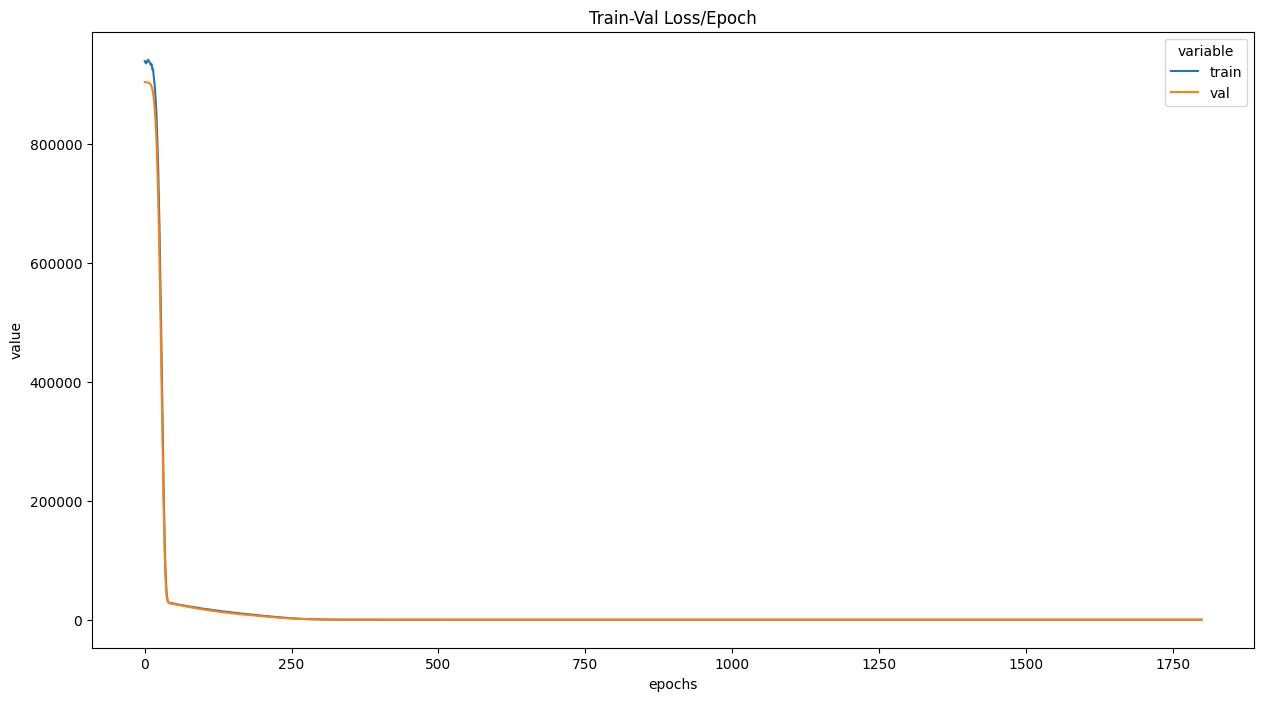

In [20]:
train_val_loss_df = (
    pd.DataFrame.from_dict(loss_stats)
    .reset_index()
    .melt(id_vars=["index"])
    .rename(columns={"index": "epochs"})
)
plt.figure(figsize=(15, 8))
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable").set_title(
    "Train-Val Loss/Epoch"
)

100%|██████████| 3/3 [00:00<00:00, 19210.55it/s]

[862.4555, 870.1154, 875.04645, 877.41455, 879.2488, 881.20215, 882.0558, 883.7129, 886.78656, 891.2073, 894.13544, 896.4614, 902.1842, 910.4511, 918.45514, 928.2599, 939.4687, 950.59, 958.9397, 963.8003, 965.145, 966.49286, 965.6708, 966.1287, 968.1199, 970.5931, 971.8447, 971.55566, 970.7346, 971.60004, 972.8141, 971.8008, 970.9656, 970.3867, 971.54266, 974.7644, 977.9971, 981.62115, 986.8891, 990.8801, 992.1594, 994.07806, 996.1279, 995.9565, 994.1722, 992.6483, 992.1858, 989.7639, 987.7766, 989.6039, 991.4584, 995.47015, 1003.23596, 1009.5261, 1012.7855, 1016.7633, 1020.1465, 1022.39185, 1027.7164, 1032.0348, 1035.4651, 1038.1373, 1040.613, 1044.1483, 1047.6962, 1048.1315, 1048.6364, 1050.3693, 1051.0933, 1048.3708, 1043.2981, 1039.1819, 1034.3667, 1031.1072, 1029.7, 1028.4087, 1023.1906, 1018.05194, 1012.4315, 1002.98236, 995.2631, 989.18823, 979.9351, 971.315, 963.80945, 956.72345, 949.9742, 945.4318, 940.6817, 938.14923, 934.7665, 931.25525, 924.75415, 919.3268, 916.65295, 916.0

[Text(0.5, 1.0, 'Deviation of Error')]

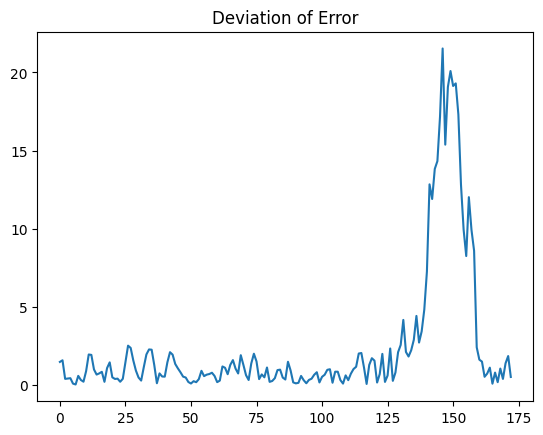

In [21]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        y_pred_list = [a for a in y_pred_list]
        
y_pred = []
for i in tqdm(range(len(y_pred_list))):
    for j in range(len(y_pred_list[i])):
        for k in range(len(y_pred_list[i][j])):
            y_pred.append(y_pred_list[i][j][k])

print(y_pred)  
print(y_test.tolist())
y_pred_np = np.array(y_pred)
difference = np.subtract(y_pred_np, y_test)
difference = abs(difference)
mean_difference = np.mean(difference)
print(f"The average deviation in error is: {mean_difference}")
sns.lineplot(difference).set(title="Deviation of Error")

In [22]:
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
mean_abs_err = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)
print(f"Accuracy (using MSE): {(100 - mse)}%")
print(f"Mean absolute percentage error: {100 - mean_abs_err}%")

Mean Squared Error : 25.846032354983492
R^2 : 0.9965909409977398
Accuracy (using MSE): 74.15396764501651%
Mean absolute percentage error: 99.99762515812724%


#### Visualising the data

In [23]:
import plotly as py
import plotly.io as pio    
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [24]:
test_vals = temp.index[x_len:]
fig = make_subplots(rows=4, cols=1)
fig.add_trace(go.Scatter(x=temp.index, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=2, col=1)


fig.add_trace(go.Scatter(x=test_vals,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=3, col=1)

# )


fig.show()